# Building a Spam Filter with Naive Bayes Algorithm

**Summary:** this project consists of building a spam filter for SMS messages with the multinominal Naïve Bayes algorithm as its core. In order to train the algorithm, we'll use a dataset of 5,572 SMS messages that are already classified by humans.  The data set is available [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip)

**Goal**: write a program that classifies new messages with an accuracy of at least 80% 

In [ ]:
import os
os.getcwd()
os.chdir("C:\\Users\\hecto\\OneDrive\\Desktop\\Data Science\\Spam Filter Project")

In [ ]:
#Importing libraries
import pandas as pd
import re
import warnings
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

## Data Overview

In [ ]:
# Importing the Data
data = pd.read_csv("DATA", sep = "\t", header = None, names=["Label","SMS"])
print(data.info())
data.head(3)

The data has two columns: Label and SMS. The SMS column contains the messages, while the Label column says the classification that humans gave to an especific  message

In [ ]:
#Plotting null values
sns.heatmap(data.isnull())

There are no NULL values

## Training and testing sub-set

In order to create the algorithm, we need a training and testing data subsets derived from the original data:

- The training subset,  which consist of 80% of the orgininal data,is  used to teach the algorithm how to classify the messages.

- The testing subset, which consist of 20% of the orgininal data, is used to determine how accurate the model is.

In [ ]:
#Randomizing the data
randomized_set = data.sample(frac=1, random_state=1).reset_index()
randomized_set = randomized_set[["Label","SMS"]]

In [ ]:
#Creating the sub sets
training_set = randomized_set.iloc[0:4458]
test_set = randomized_set.iloc[4458:]

In [ ]:
#Ploting the spam and non messages distribution for all data sets

fig = plt.figure()

ax1 =fig.add_axes([1,2,0.7,0.7])
ax1.bar(data["Label"].value_counts().index,data["Label"].value_counts(),width=0.5)
ax1.set_title("Number of Spam and Non Spam SMS for the Original Data")

ax2 = fig.add_axes([1,1,0.7,0.7])
ax2.bar(training_set["Label"].value_counts().index,training_set["Label"].value_counts(),width=0.5)
ax2.set_title("Number of Spam and Non Spam SMS for the Training Data")

ax3 = fig.add_axes([2,2,0.7,0.7])
ax3.bar(test_set["Label"].value_counts().index,test_set["Label"].value_counts(),width=0.5)
ax3.set_title("Number of Spam and Non Spam SMS for the Test Data")

plt.show()

All data set have a similar distribution of spam and non spam messages

In [ ]:
warnings.filterwarnings("ignore")

## The Final Training Set

We're now going to create a vocabulary and use it to create the final training set, which counts how many times each word is used for each message.

In [ ]:
#Removing the punctuation and bringing all the words to lower case in the training set

training_set["SMS"] = training_set["SMS"].str.replace("\W"," ").str.lower() # /W = Negative Word \W Any character except word characters
training_set["SMS"] = training_set["SMS"].str.split()
training_set.head(3)

In [ ]:
#Creating a list with all the unique words in the training set SMS column

vocabulary = []

for message in training_set["SMS"]:
    for word in message:
        if word in vocabulary:
            pass
        else:
            vocabulary.append(word)
            
print("There are " + str(len(vocabulary)) + " unique words in the training set SMS column")
vocabulary[0:5]

In [ ]:
#Creating a dictionary 
word_counts_per_sms = {unique_word:[0] * len(training_set)for unique_word in vocabulary}

for index, message in enumerate(training_set["SMS"]):
    for word in message:
        word_counts_per_sms[word][index] += 1
        
word_counts_per_sms = pd.DataFrame(word_counts_per_sms)
training_set_clean = pd.concat([training_set,word_counts_per_sms],axis=1)
training_set_clean.head(3)

## Naive Bayes classifier

The Naive Bayes algorithm is a “probabilistic classifier” based on the Bayes' theorem, which describes the probability of an event based on prior knowledge of conditions that might be related to that event. We'll need the following probability values of the two equations below to be able to classify new messages.

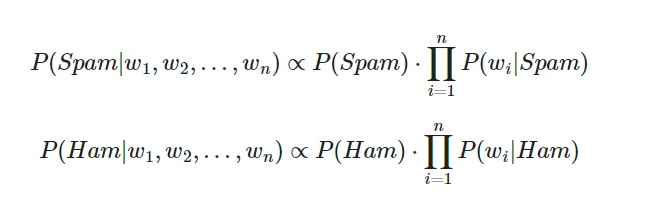

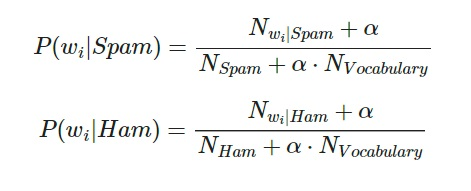

### Constants

* **NSpam** is equal to the number of words in all the spam messages — it's not equal to the number of spam messages, and it's not equal to the total number of unique words in spam messages.
<br/><br/>

* **NHam** is equal to the number of words in all the non-spam messages — it's not equal to the number of non-spam messages, and it's not equal to the total number of unique words in non-spam messages.
<br/><br/>
* **Nwi** = the number of times a word repeats it self.
<br/><br/>
* **Nvocabulary** = number of times an especific word repeats itself.
<br/><br/>
* **P(Spam)** = probability of a SMS being a spam in the training (tr) data set.
<br/><br/>
* **P(Ham)** = probability of a SMS not beign a spam in the training (tr) data set.
<br/><br/>
* We'll also use Laplace smoothing and set **α=1**.

In [ ]:
#Isolating the spam and the ham messages in the training set into two different DataFrames
tr_set_spam = training_set_clean[training_set_clean["Label"] =="spam"]
tr_set_ham = training_set_clean[training_set_clean["Label"] =="ham"]

tr_spam_count = len(tr_set_spam)
tr_ham_count = len(tr_set_ham)

In [ ]:
#Calculating the probability of a SMS being a spam or not
tr_total_count = tr_spam_count + tr_ham_count
tr_spam_p = tr_spam_count / tr_total_count
tr_ham_p = tr_ham_count / tr_total_count

#Isolation spam and non spam messages 
tr_spam_messages = training_set_clean["SMS"][training_set_clean["Label"] == "spam"]
tr_ham_messages = training_set_clean["SMS"][training_set_clean["Label"] == "ham"]

#Counting the number of words for spam and non spam messages and the Vocabulary

n_spam = 0
for sms in tr_spam_messages:
    n_spam += len(sms)

n_ham = 0 
for sms in tr_ham_messages:
    n_ham += len(sms)
    
n_vocabulary = len(vocabulary)

#Alpha

alpha = 1

### Calculating Parameters

In [ ]:
#creating a dictionary with each of the vocabularys word with a 0 as their value
parameters_spam = {word:0 for word in vocabulary}
parameters_ham = {word:0 for word in vocabulary}


#Calculate parameters
for word in vocabulary:
    n_word_given_spam = tr_set_spam[word].sum()
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = tr_set_ham[word].sum()
    p_word_given_ham = (n_word_given_ham + alpha) /  (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham
    
parameters_spam

###  Classifying A New Message

Now that we have all our parameters calculated, we can start creating the spam filter. The spam filter can be understood as a function that:

- Takes in as input a new message (w1, w2, ..., wn).
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn).
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
- If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
- If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
- If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

In [ ]:
def classify(message):
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = tr_spam_p
    p_ham_given_message = tr_ham_p

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
   
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'Equal proabilities, have a human classify this!'

In [ ]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

In [ ]:
classify("Hola comoe estas?")

In [ ]:
classify("Sounds good, Tom, then see u there")

# Measuring the Spam Filter's Accuracy

In [ ]:
# Determining the number and percentage of spam messages in the training and testing set
tr_spam = training_set["Label"]=="spam"
ts_spam = test_set["Label"] == "spam"
print("The training set has " + str(tr_spam.value_counts()[1]) + " spam messages out the " + str(len(training_set))) 
print("The testing set has " + str(ts_spam.value_counts()[1]) + " spam messages out of the " + str(len(test_set)))

We  are going to create a new column in our test set.

In [ ]:
test_set['predicted'] = test_set['SMS'].apply(classify)
test_set.head(3)

In [ ]:
accuracy_test = (test_set["Label"] == test_set["predicted"]).value_counts()
accuracy_test = pd.DataFrame(accuracy_test).rename(columns={0:"Results"})
accuracy_test.loc["Accuracy % "] = (accuracy_test.iloc[0]/accuracy_test.sum()) * 100 
accuracy_test.style.format("{:,.0f}")

The filter looked at 1,114 messages that it hasn't seen in training, and classified 961 correctly.The algorithm is 86% accurate.